## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
pd.set_option('float_format', '{:.02f}'.format)
%precision %.4f

'%.4f'

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.1197

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
old_treat = df[(df.landing_page == "old_page") & (df.group == "treatment")]
old_treat.count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

In [8]:
new_control = df[(df.landing_page == "new_page") & (df.group == "control")]
new_control.count()

user_id         1928
timestamp       1928
group           1928
landing_page    1928
converted       1928
dtype: int64

In [9]:
not_line_up = old_treat.count() + new_control.count()
not_line_up

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [10]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> No

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now create a new dataset that meets the specifications.  Store your new dataframe in **df2**.

In [11]:
old_index = old_treat.index
new_index = new_control.index

In [12]:
df.drop(old_index, inplace = True)
df.drop(new_index, inplace = True)

In [13]:
df2 = df

In [14]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer the following questions.

a. How many unique **user_id**s are in **df2**?

In [15]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
duplicate_user = df2[df2.user_id.duplicated()]
duplicate_user.user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [17]:
duplicate_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [18]:
df2.drop_duplicates('user_id', inplace = True)

`4.` Use **df2** in the below cells to answer the questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2.converted.mean()

0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
ctrl_group = df2[df2.group == 'control']
ctrl_group.converted.mean()

0.1204

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
treat_group = df2[df2.group == 'treatment']
treat_group.converted.mean()

0.1188

d. What is the probability that an individual received the new page?

In [22]:
np_count = df2[df2.landing_page == 'new_page'].landing_page.count()
op_count = df2[df2.landing_page == 'old_page'].landing_page.count()
total_count = np_count + op_count

In [23]:
np_count/total_count

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

> There is a 50% chance of someone receiving either page and a 0.08% difference from the mean for converting. Therefore, there is a small chance that either page has a statistical significance but not a practical significance. 

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$

> * Null = The probability of converting for the new page is less than or equal to the probability of converting for the old page.
> * Alternative = The probability of converting for the new page is greater than the probability of converting for the old page. 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
p_new = (df2.converted == 1).mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
p_old = (df2.converted == 1).mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [26]:
n_new = treat_group.user_id.count()
n_new

145310

d. What is $n_{old}$?

In [27]:
n_old = ctrl_group.user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
p_new_sim = new_page_converted.mean()
p_old_sim = old_page_converted.mean()
p_new_sim, p_old_sim

(0.12114100887757209, 0.11960846400594738)

In [31]:
obs_diff = p_new_sim - p_old_sim
obs_diff

0.0015325448716247136

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [32]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
    p_new_sim = new_page_converted.mean()
    p_old_sim = old_page_converted.mean()
    diff = p_new_sim - p_old_sim
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?

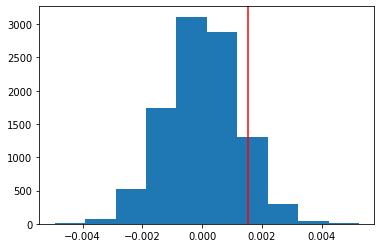

In [33]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
(p_diffs > obs_diff).mean()

0.0989

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = p_old
convert_new = p_new
n_old, n_new

(145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score)
print(p_value)

-6.059074386432219e-05
0.5000241722095137


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> The z-score is -6.059 which means that it is 6 standard deviations below the mean. This would indicate a failure to reject the null hypothesis. 

> The p-value is less than the other p-value calculated but still above the error rate of 0.05, therefore we would still fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> Logistic

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [38]:
df2[['ab_page']] = pd.get_dummies(df2['group'], drop_first=True)

In [39]:
df2['intercept'] = 1

In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [41]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        13:38:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

> The p-value associated with `ab_page` is 0.190.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> Adding additional terms in the regression model would help focus in on whether the conversion rate for the old or new pages is statistically significant. 

> The only drawback to adding additional terms would be if there was multi-collinearity between the terms which would throw off the results of the A/B test. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. 

Does it appear that country had an impact on conversion?  

In [43]:
# reading in the new dataframe and joining to the old one
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [44]:
# creating dummy variables for the new table
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [45]:
df_new = df_new.drop('US', axis=1)

In [46]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [47]:
logit_mod_new = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results_new = logit_mod_new.fit()
results_new.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        13:38:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [48]:
ab_page_coeff = 1/np.exp(-0.0149)
CA_coeff = 1/np.exp(-0.0408)
UK_coeff = 1/np.exp(0.0099)

In [49]:
ab_page_coeff, CA_coeff, UK_coeff

(1.0150115583846535, 1.0416437559600236, 0.9901488436829571)

> An individual converting is 1.015 times as likely on the new page than on the old page, holding all else constant.

> An individual is 1.042 times more likely to convert if they are from the United States than if they are from Canada, holding all other variables constant. 

> An individual is 0.99 times more likely to convert if they are from the United States than if they are from the United Kingdom, hold all other variables constant. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [50]:
df_new['ab_page_CA'] = df_new['ab_page'] * df_new['CA']
df_new['ab_page_UK'] = df_new['ab_page'] * df_new['UK']

In [51]:
logit_mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA',
                                                   'UK', 'ab_page_CA', 'ab_page_UK']])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:               3.482e-05
Time:                        13:38:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

In [52]:
exp_coeff = np.exp(results3.params)
1/exp_coeff

intercept    7.29
ab_page      1.02
CA           1.02
UK           1.01
ab_page_CA   1.05
ab_page_UK   0.97
dtype: float64

> Since each coefficient is almost exactly 1, and the p-values are relatively high, there does not seem to be any statistical or practical significance in the new page attributing to conversion. 